In [1]:
# Cell 1: Import necessary libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.applications import EfficientNetV2S
# from keras.applications import EfficientNetV2L

In [2]:
# Cell 2: Define constants
BATCH_SIZE = 16
# IMG_HEIGHT = 380 efficientnetv2L
# IMG_WIDTH = 380
IMG_HEIGHT = 300
IMG_WIDTH = 300 #for EfficientNetV2S
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Segmented_Dataset"

In [3]:
# Cell 3: Define data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.3),
        layers.RandomBrightness(0.4),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomCrop(IMG_HEIGHT, IMG_WIDTH)
    ]
)

In [7]:
# Cell 4: Load data
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 1500 files belonging to 15 classes.
Using 1200 files for training.
Found 1500 files belonging to 15 classes.
Using 300 files for validation.


In [8]:
# Cell 5: Preprocess data
train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))
val_ds = val_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))

In [9]:
# Cell 6: Build model
inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model = EfficientNetV2S(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization

# Compile
model = keras.Model(inputs, outputs, name="EfficientNet")
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


82420632/82420632 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install pydot graphviz

In [ ]:
model.summary()

In [10]:
# Cell 7: Define callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Checkpoints/Segmented_Data/checkpoint-{epoch:02d}-{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)


In [11]:
#Cell 8 train the model
epochs = 10
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint])


Epoch 1/10
75/75 [==============================] - ETA: 0s - loss: 1.7401 - accuracy: 0.5758

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 179s 2s/step - loss: 1.7401 - accuracy: 0.5758 - val_loss: 1.9446 - val_accuracy: 0.7533
Epoch 2/10
75/75 [==============================] - 44s 581ms/step - loss: 0.8608 - accuracy: 0.8408 - val_loss: 1.3536 - val_accuracy: 0.8633
Epoch 3/10
75/75 [==============================] - 44s 590ms/step - loss: 0.6380 - accuracy: 0.8958 - val_loss: 0.8543 - val_accuracy: 0.9700
Epoch 4/10
75/75 [==============================] - 43s 575ms/step - loss: 0.6012 - accuracy: 0.9092 - val_loss: 0.6478 - val_accuracy: 0.9367
Epoch 5/10
75/75 [==============================] - 45s 598ms/step - loss: 0.4929 - accuracy: 0.9383 - val_loss: 0.4404 - val_accuracy: 0.9767
Epoch 6/10
75/75 [==============================] - 45s 598ms/step - loss: 0.4816 - accuracy: 0.9350 - val_loss: 0.3871 - val_accuracy: 0.9800
Epoch 7/10
75/75 [==============================] - 46s 616ms/step - loss: 0.4697 - accuracy: 0.9375 - val_loss: 0.3500 - val_accuracy: 0.9767
Epoch 8/10
7

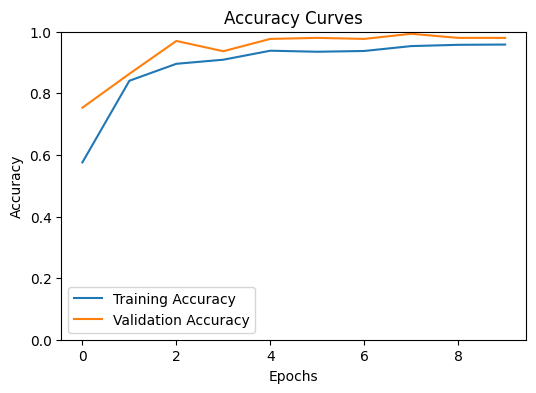

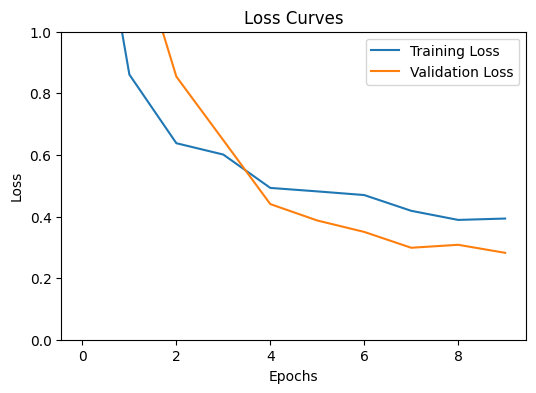

In [12]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()


In [13]:
# Cell 9: Unfreeze model and continue training
for layer in model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 5
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/5
75/75 [==============================] - 61s 602ms/step - loss: 0.3656 - accuracy: 0.9600 - val_loss: 0.2611 - val_accuracy: 0.9867
Epoch 2/5
75/75 [==============================] - 45s 598ms/step - loss: 0.3549 - accuracy: 0.9575 - val_loss: 0.2636 - val_accuracy: 0.9833
Epoch 3/5
75/75 [==============================] - 43s 569ms/step - loss: 0.3472 - accuracy: 0.9633 - val_loss: 0.2792 - val_accuracy: 0.9767
Epoch 4/5
75/75 [==============================] - 43s 574ms/step - loss: 0.3361 - accuracy: 0.9650 - val_loss: 0.2731 - val_accuracy: 0.9833
Epoch 5/5
75/75 [==============================] - 43s 570ms/step - loss: 0.3389 - accuracy: 0.9675 - val_loss: 0.2541 - val_accuracy: 0.9900


In [14]:
# Cell 10: Save the model
model.save('/content/drive/MyDrive/Colab Notebooks/EfficientNetV2S.h5')


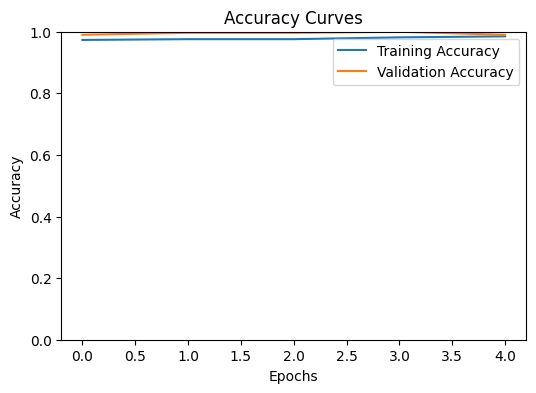

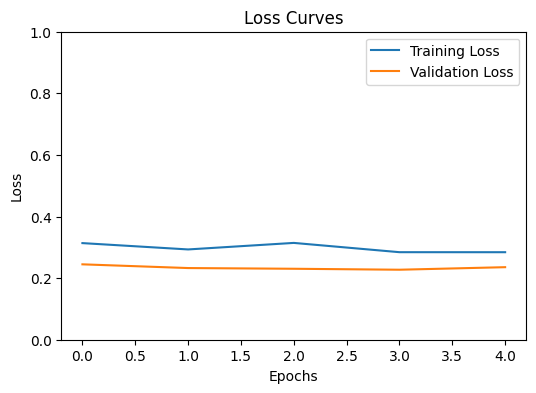

In [29]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()
